# Lab #6: Interpreting and Evaluating Logistic Regression Models
## AM 207: Advanced Scientific Computing
### Stochastic Methods for Data Analysis, Inference and Optimization
### Fall, 2019

<img src="fig/logos.jpg" style="height:150px;">

In [1]:
### Import basic libraries
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from pymc3 import model_to_graphviz, Model
import pymc3 as pm
%matplotlib inline

In [2]:
def plot_decision_boundary(x, y, models, ax, poly_degree=1):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       model - the 'sklearn' classification model
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
    returns: 
       ax - the axis with the scatter plot
    
    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    
    # Create mesh
    interval = np.arange(-4, 4.1, 0.1)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree)
        xx = polynomial_features.fit_transform(xx)
    
    if len(models) > 1:
        alpha_line = 0.1
    else:
        alpha_line = 1.
        
    i = 0
    
    for model in models:
        yy = model.predict(xx)  
        yy = yy.reshape((n, n))

        # Plot decision surface
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        ax.contourf(x1, x2, yy, alpha=0.2 * 1. / (i + 1)**2, cmap='bwr')
        ax.contour(x1, x2, yy, colors='black', linewidths=0.5, alpha=alpha_line)
        
        i += 1
        
    ax.set_xlim((-4, 4))
    ax.set_ylim((-4, 4))
    ax.set_xlabel('marker 1')
    ax.set_ylabel('marker 2')
    ax.legend(loc='best')
    return ax

## Problem Description: Modeling Preterm Births

You are given the birth mother data (normalized) for approximately 2,000 new borns in California between the years 2000 and 2001 (`lab_6_data.csv`). Previous studies have indicated that demographic factors of the birth mother strongly affects the risk of preterm births (preterm here means a gestational age of less than 37 weeks). Your task is to investigate whether or not this assertion holds for the dataset at hand. 

### Modeling for Testing Scientific Hypotheses
We can investigate our hypothesis -- that demographic factors of the birth mother strongly affects the risk of preterm births -- in multiple ways:

1. visualize the joint distribution of the covariates -- color preterm births differently than the full term births. From the way the data looks, is there any evidence to support our hypothesis?<br><br>

2. visualize marginal distribution of the covariates. For each covariate, make two histograms on the same plot, one for preterm births, another for full-term births. From the way the marginals look, is there any evidence to support our hypothesis?<br><br>

3. in the lecture notes for logistic regression, we showed that fitting a logistic regression model to explain Bernoulli outcomes is the same as fitting a hyperplane (a decision boundary) to separate (or classify) two classes of data in covariate-space. Use `sklearn`'s logistic regression model (set the parameter `C` to be large), to find the MLE of the coefficients of a logistic regression model for this dataset. <br><br>

  1. Extract and interpret the MLE coefficients found by your `sklearn` model (`coef_`, `intercept_`). What do these coefficients tell you about the relationship between demographic factors of the birth mother and the risk of preterm birth?<br><br>
  
  2. Visualize the decision boundary of the MLE logistic regression model using the `plot_decision_boundary` function provided to you. What does this visualization tell you about the reliability of your conclusions about the relationship between demographic factors of the birth mother and the risk of preterm birth?<br><br>
  
### Model Evaluation

#### Predictiveness
There are multiple ways to evaluate your logistic regression model:

1. One way is to predict or classify data points as preterm or full term depending on the $\theta^{(n)}$ that your model predicts for the $n$-th observation. You can then evaluate the predictive accuracy (use `sklearn`'s `.score()` function). What does the predictive accuracy of your model tell you about the reliability of your conclusions about the relationship between demographic factors of the birth mother and the risk of preterm birth?<br><br>
     
2. Another way to evaluate your model is to look at the actual probabilities $\theta^{(n)}$'s that it predicts. We bin the observations according to the value of $\theta^{(n)}$ predicted by the model, for a fixed bin ( $a<\theta^{(n)}<b$ ) we compute the actual percentage of observations that have label $y=1$ and compare with the predicted percentage $\theta_n$. We say a model is miscalibrated if the predicted percentage is consistently different from the actual. We can plot the actual percentage against the predicted in a ***calibration plot*** (use `sklearn.calibration.calibration_curve`). What does your calibration plot say about your model?

#### Uncertainty
Evaluating a single MLE model fitted on the observed data gives you no sense of how sensitive the model is to small changes in the data. We can easily test our model's sensitivity:

1. bootstrapping your data, fit 100 MLE logistic regression models. Compute the mean MLE coefficients (averaged over 100 bootstrap estimates). What do these coefficients tell you about the relationship between demographic factors of the birth mother and the risk of preterm birth?

2. visualize the decision boundaries of all of these boostrap MLE models. What does this visualization tell you about the reliability of your conclusions about the relationship between demographic factors of the birth mother and the risk of preterm birth?

### A Bayesian Approach

Repeat all of the above for a Bayesian logistic regression model of your data. In particular, compare the uncertainty estimation:

1. Compare the uncertainty from the bootstrap MLE and the uncertainty from the posterior of the Bayesian model, which type of uncertainty is more reliable or informative? Why?

### Data Heterogeneity

Recall from the many examples from lecture and homework that it is often useful to break up the data into categories and fit a model for each category. This is especially true if the variations in the data is heterogeneous. 

1. look at the our data, is there any heterogeneity in the data? Do you think there would be any benefit in break up the data and fitting separate models for each subset?<br><br>

2. in the case of the kidney cancer data set, it was easy to break up the data into categories based on the county. If we wanted to break up this dataset, how would we do it?

In [3]:
df = pd.read_csv('lab_6_data.csv')
df.head()

,mothers income (normalized),mothers age (normalized),preterm
0,-0.400228,-0.926880,0
1,1.076102,1.180291,1
2,-0.922953,0.306167,0
3,0.897991,2.407370,1
4,1.506738,2.583626,1


In [4]:
X = df[['mothers income (normalized)', 'mothers age (normalized)']].values
y = df['preterm'].values

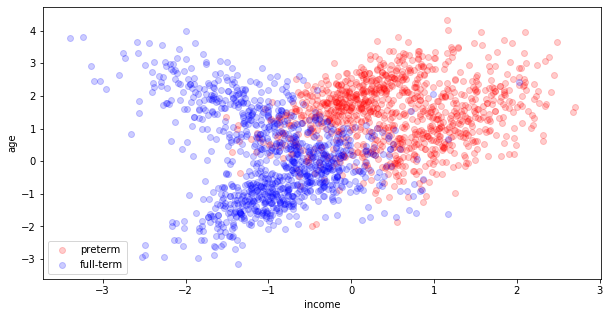

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='preterm', alpha=0.2)
ax.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='full-term', alpha=0.2)
ax.set_xlabel('income')
ax.set_ylabel('age')
ax.legend(loc='best')
plt.show()

Notice that the data is heterogneous -- it doesn't fall nicely into two clumps (pre-term, full-term). Within each category, there is a lot of variation -- each category looks to contain two subclasses.

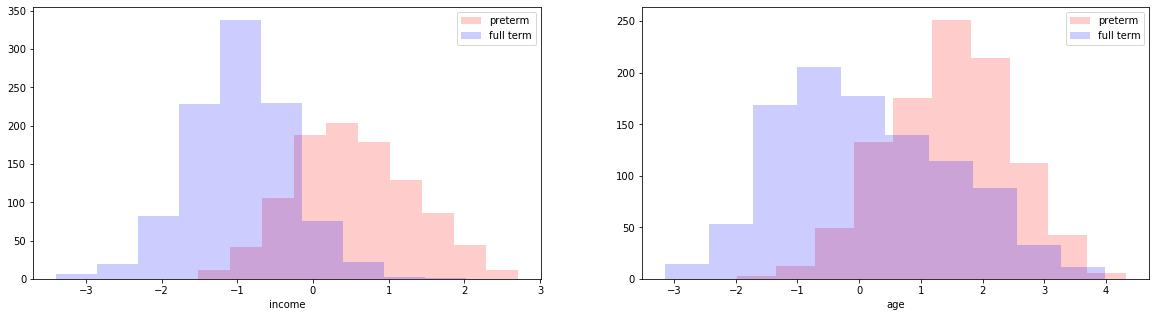

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].hist(X[y == 1][:, 0], label='preterm', color='red', alpha=0.2)
ax[0].hist(X[y == 0][:, 0], label='full term', color='blue', alpha=0.2)
ax[0].set_xlabel('income')
ax[0].legend(loc='best')
ax[1].hist(X[y == 1][:, 1], label='preterm', color='red', alpha=0.2)
ax[1].hist(X[y == 0][:, 1], label='full term', color='blue', alpha=0.2)
ax[1].set_xlabel('age')
ax[1].legend(loc='best')
plt.show()

In [7]:
logistic = LogisticRegression(random_state=0, C=1e10, solver='lbfgs')
logistic.fit(X, y)

LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

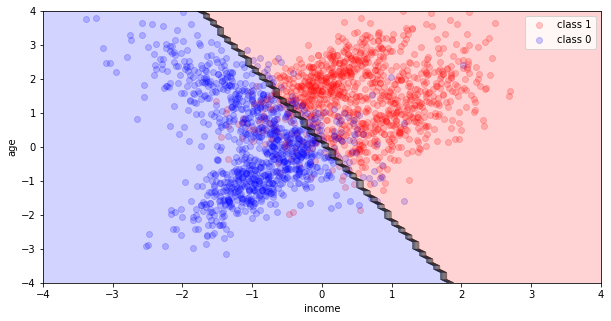

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_decision_boundary(X, y, [logistic], ax, poly_degree=1)
ax.set_xlabel('income')
ax.set_ylabel('age')
ax.legend(loc='best')
plt.show()

In [9]:
print('the accuracy of our logistic regression model as a classifier is:', logistic.score(X, y))

the accuracy of our logistic regression model as a classifier is: 0.8935


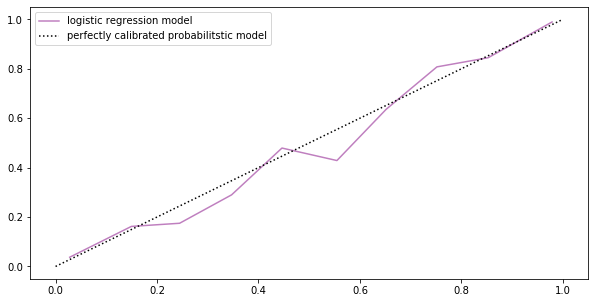

In [10]:
prob_pos = logistic.predict_proba(X)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y, prob_pos, n_bins=10)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(mean_predicted_value, fraction_of_positives, color='purple', alpha=0.5, label='logistic regression model')
ax.plot([0, 1], [0, 1], 'k:', label='perfectly calibrated probabilitstic model')
ax.legend(loc='best')
plt.show()

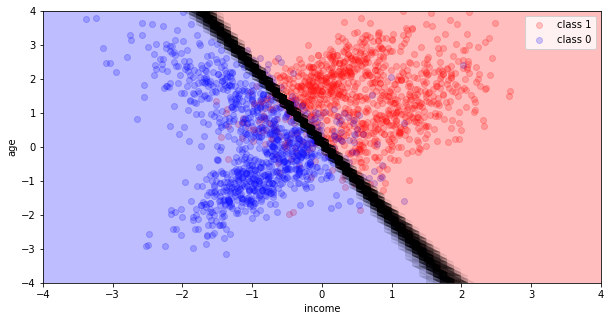

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
models = []

for i in range(100):
    bootstrap_indices = np.random.choice(np.arange(0, len(y)), size=len(y))
    X_bootstrap = X[bootstrap_indices]
    y_bootstrap = y[bootstrap_indices]
    logistic = LogisticRegression(random_state=0, C=1e10, solver='lbfgs')
    logistic.fit(X_bootstrap, y_bootstrap)
    models.append(logistic)

ax = plot_decision_boundary(X, y, models, ax, poly_degree=1)
ax.set_xlabel('income')
ax.set_ylabel('age')
ax.legend(loc='best')
plt.show()

In [12]:
with pm.Model() as bayesian_model:
    #define priors
    slopes = pm.Normal('slopes', mu=0, tau=1./10, shape=2)
    intercept = pm.Normal('intercept', mu=0, tau=1./10)
    
    #define linear model, using marital status as a covariate
    mu = intercept + pm.math.dot(X, slopes) 
    #transform linear model into a probability
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))

    #define binomial likelihood
    y_observed = pm.Bernoulli('y_obs',  p=theta, observed=y)

    trace = pm.sample(4000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slopes]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1038.42draws/s]


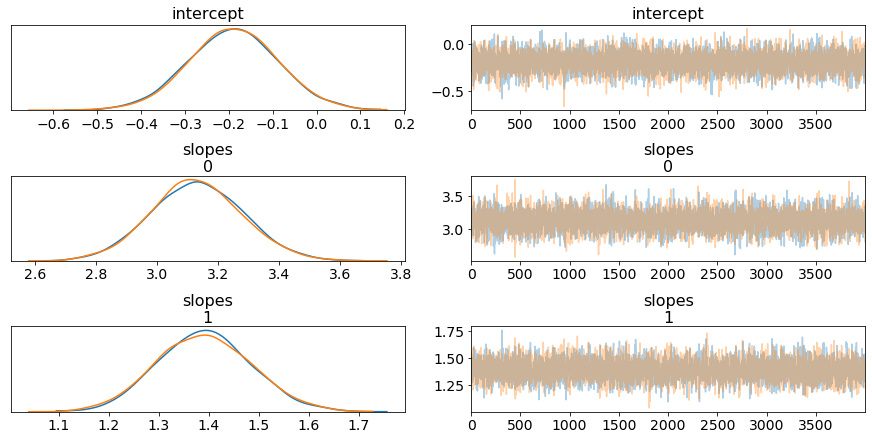

In [13]:
pm.traceplot(trace, var_names= ['intercept', 'slopes'])
plt.show()

In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
class Bayesian_logistic_regression:
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes
    def predict(self, x):
        y = sigmoid(x.dot(self.slopes) + self.intercept)
        return (y > 0.5).astype(np.int_)

In [15]:
thinned_trace = trace[::10]
posterior_samples_index = np.random.choice(np.arange(len(thinned_trace)), size=100)
models = []

for index in posterior_samples_index:
    sample = thinned_trace[index]
    model = Bayesian_logistic_regression(sample['intercept'], sample['slopes'])
    models.append(model)

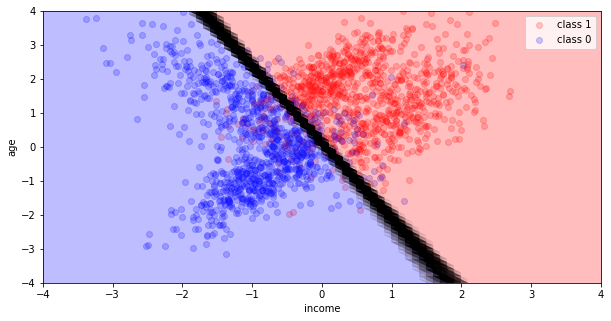

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_decision_boundary(X, y, models, ax, poly_degree=1)
ax.set_xlabel('income')
ax.set_ylabel('age')
ax.legend(loc='best')
plt.show()